In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import pymongo
import pickle
import bson

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Other external scripts
import lst1_mongodb_example
import utils

client_tcu  = pymongo.MongoClient("localhost:27017")
client_caco = pymongo.MongoClient("localhost:27018")

read_db = False

#### TCU properties:

In [2]:
!python lst1_mongodb_example.py --list-available

---                                          ---
---         Available property names         ---
---                                          ---
  0 : AMC_Master_ActuatorErrorCode
  1 : AMC_Master_ActuatorHumidity
  2 : AMC_Master_ActuatorPosition
  3 : AMC_Master_ActuatorPositionDeviation
  4 : AMC_Master_ActuatorSignalStrength
  5 : AMC_Master_ActuatorTemperature
  6 : AMC_Master_ConfiguredZenithAngle
  7 : AMC_Master_ErrorCode
  8 : AMC_Master_FSM_state
  9 : AMC_Master_FSM_transition
 10 : AMC_Master_HeartbeatTimestamp
 11 : AMC_Master_SlaveInTransition
 12 : AMC_Master_SlaveStates
 13 : AMC_Master_SlavesConnected
 14 : AMC_Master__Enable_Heart_Beat
 15 : AMC_Master__Error_Heart_Beat
 16 : AMC_Master__Heart_Beat
 17 : AMC_Master__Heart_Beat_TimeOut
 18 : AMC_PSF_CCDPower
 19 : AMC_PSF_CCDTemperature
 20 : AMC_PSF_ConfiguredExposure
 21 : AMC_PSF_CooledDown
 22 : AMC_PSF_FSM_state
 23 : AMC_PSF_FSM_transition
 24 : AMC_PSF_GrowthCurve
 25 : AMC_PSF_HeartbeatTimestamp
 26 : AMC_PSF

#### CaCo databases and collections:

In [3]:
client_caco = pymongo.MongoClient("localhost:27018")

all_databases = np.sort(client_caco.list_database_names())

print(f"--- {'':^40s} ---")
print(f"--- {'Available CaCo databases and collections':^40s} ---")
print(f"--- {'':^40s} ---")
for database in all_databases:
    print(f"\n--- {f'Database - {database}':^40s} ---")
    
    all_collections = np.sort(client_caco[database].list_collection_names())
    for i, collection in enumerate(all_collections):
        print(f"{i:4d} : {collection}")

---                                          ---
--- Available CaCo databases and collections ---
---                                          ---

---             Database - CACO              ---
   0 : CBOX_day
   1 : CBOX_hour
   2 : CBOX_min
   3 : CBOX_week
   4 : CLUSCO_day
   5 : CLUSCO_hour
   6 : CLUSCO_min
   7 : CLUSCO_week
   8 : ECC_day
   9 : ECC_hour
  10 : ECC_min
  11 : ECC_week
  12 : EVB_day
  13 : EVB_hour
  14 : EVB_min
  15 : EVB_week
  16 : RUN_INFORMATION
  17 : STATE
  18 : TIB_day
  19 : TIB_hour
  20 : TIB_min
  21 : TIB_week

---         Database - CALIBRATIONS          ---
   0 : dtn
   1 : external_delay
   2 : external_gain
   3 : internal_delay
   4 : internal_gain

---             Database - SCANS             ---
   0 : IPRScan
   1 : L1Scan

---             Database - admin             ---
   0 : system.version

---            Database - config             ---
   0 : system.sessions

---             Database - local             ---
   0 : startup_log



#### All properties from CaCo database:

In [4]:
# Selecting CaCo database
caco_db = client_caco.CACO

dict_caco_names = {}
all_collections = np.sort(caco_db.list_collection_names())
for coll_name in all_collections:
    coll = caco_db[coll_name]
    if coll not in ["STATE", "RUN_INFORMATION"] and "week" in coll_name:
    
        print(f"\n--- {f'Collection - {coll_name}':^40s} ---")
        names = coll.distinct("name")
        
        dict_caco_names[coll_name.replace("week", "min")] = names
        for i,n in enumerate(names):
            print(f"{i:4.0f} : {n}")


---          Collection - CBOX_week          ---
   0 : CBOX_DewPoint
   1 : CBOX_Error_InterCalibration_Mean
   2 : CBOX_FSM_state
   3 : CBOX_Humidity
   4 : CBOX_InterCalibration_Mean
   5 : CBOX_LaserStatus
   6 : CBOX_LaserTrigParameters1
   7 : CBOX_LaserTrigParameters2
   8 : CBOX_Pressure
   9 : CBOX_Temperature
  10 : CBOX_WheelPosition1
  11 : CBOX_WheelPosition2

---         Collection - CLUSCO_week         ---
   0 : backplane_error_flag
   1 : backplane_firmware
   2 : backplane_temperature
   3 : clusco_busy_state
   4 : clusco_hv_on
   5 : clusco_l0_hot
   6 : clusco_l0_rate_control
   7 : clusco_l0_rate_max
   8 : clusco_l1_rate_control
   9 : clusco_l1_rate_max
  10 : clusco_l1_rate_target
  11 : clusco_mean_dc
  12 : clusco_mean_dc_healthy
  13 : clusco_nb_hv_reduced
  14 : clusco_zenith
  15 : cluster_status
  16 : dragon_busy
  17 : dragon_drs_cascade_channels
  18 : dragon_drs_read_depth
  19 : dragon_drs_sampling_frequency
  20 : dragon_drs_trigger_selection
  21

In [5]:
%%time
if read_db:
    
    # Reading TCU database
    print("Reading TCU database")
    records_tcu  = get_records(client_tcu,  "lst1_obs_summary", "camera", query)

    # Reading CaCo database
    print("Reading CaCo database")
    records_caco = get_records(client_caco, "CACO", "RUN_INFORMATION", query)  
    
    # Saving the objects
    with open("objects/records_tcu.pkl", "wb") as f:
        pickle.dump(records_tcu, f, pickle.HIGHEST_PROTOCOL)
    with open("objects/records_caco.pkl", "wb") as f:
        pickle.dump(records_caco, f, pickle.HIGHEST_PROTOCOL)

else:
    
    # Reading the saved objects
    with open("objects/records_tcu.pkl", "rb") as f:
        records_tcu = pickle.load(f)
    with open("objects/records_caco.pkl", "rb") as f:
        records_caco = pickle.load(f)

CPU times: user 284 ms, sys: 269 ms, total: 553 ms
Wall time: 552 ms


In [76]:
!python lst1_mongodb_example.py --list-available

---                                          ---
---         Available property names         ---
---                                          ---
  0 : AMC_Master_ActuatorErrorCode
  1 : AMC_Master_ActuatorHumidity
  2 : AMC_Master_ActuatorPosition
  3 : AMC_Master_ActuatorPositionDeviation
  4 : AMC_Master_ActuatorSignalStrength
  5 : AMC_Master_ActuatorTemperature
  6 : AMC_Master_ConfiguredZenithAngle
  7 : AMC_Master_ErrorCode
  8 : AMC_Master_FSM_state
  9 : AMC_Master_FSM_transition
 10 : AMC_Master_HeartbeatTimestamp
 11 : AMC_Master_SlaveInTransition
 12 : AMC_Master_SlaveStates
 13 : AMC_Master_SlavesConnected
 14 : AMC_Master__Enable_Heart_Beat
 15 : AMC_Master__Error_Heart_Beat
 16 : AMC_Master__Heart_Beat
 17 : AMC_Master__Heart_Beat_TimeOut
 18 : AMC_PSF_CCDPower
 19 : AMC_PSF_CCDTemperature
 20 : AMC_PSF_ConfiguredExposure
 21 : AMC_PSF_CooledDown
 22 : AMC_PSF_FSM_state
 23 : AMC_PSF_FSM_transition
 24 : AMC_PSF_GrowthCurve
 25 : AMC_PSF_HeartbeatTimestamp
 26 : AMC_PSF

In [34]:
dict_caco_states = {0 : "OFF", 1 : "DATA_MONITORING", 2 : "MONITORED", 3 : "SAFE", 4 : "STANDBY",
                    5 : "READY", 6 : "OBSERVING", 7 : "TPOINT", 8 : "UNDEFINED", 9 : "TRANSITIONAL", 10 : "ERROR"}
dict_caco_state_colors = {0 : "k", 1 : "darkviolet", 2 : "darkviolet", 3 : "lime", 4 : "gold",
                          5 : "c", 6 : "darkblue", 7 : "b", 8 : "r", 9 : "darkorange", 10 : "r"}

variable_tcu = "CameraControl_FSM_state"
tstart = datetime.fromisoformat("2024-01-01-00:00:00")
tstop  = datetime.fromisoformat("2024-04-01-00:00:00")


out_tcu = lst1_mongodb_example.get_entries(client_tcu, variable_tcu, astropy_time=False, tstart=tstart, tstop=tstop)
date_tcu, value_tcu = np.array(out_tcu["time"]), np.array(out_tcu["value"])

value_str_tcu = np.array([dict_caco_states[v] for v in value_tcu])

#### Extracting the timespans of each state

In [77]:
# Creating a timespan dictionary for each key
timespans_dict = {}
for key in dict_caco_states.keys():
    timespans_dict[key] = {"tstart" : [], "tstop" : []}

before_state = value_tcu[0]
initial_time = date_tcu[0]
for i in range(len(value_tcu))[1:]:
    
    actual_state = value_tcu[i]

    if before_state != actual_state:
        final_time = date_tcu[i]

        timespans_dict[actual_state]["tstart"].append(initial_time)
        timespans_dict[actual_state]["tstop"].append(final_time)

        initial_time = date_tcu[i]
        
    before_state = actual_state

#### Getting all TCU property names

In [99]:
string_properties = !python lst1_mongodb_example.py --list-available
all_tcu_properties = np.array([s.split(" : ")[-1] for s in string_properties[3:]])

camera_related_tcu_properties = []
non_camera_properties_prefix = ["AMC_", "AuxControl_", "CDM2_", "DriveControl_", "SecurityBrokerControl_"]

for p in all_tcu_properties:
    flag_camera = True
    for non_p in non_camera_properties_prefix:
        if non_p in p:
            flag_camera = False
            break
    if flag_camera:
        camera_related_tcu_properties.append(p)

print(f"There are {len(all_tcu_properties)} TCU properties in total")
print(f"There are {len(camera_related_tcu_properties)} TCU Camera-related properties in total")

There are 1159 TCU properties in total
There are 498 TCU Camera-related properties in total


#### Getting the entries for each state

In [147]:
%%time
# Creating a dictionary to store the information
event_dict = {}
for key in dict_caco_states.keys():
    event_dict[key] = {"timestamp" : [], "bytes" : []}

# Taking the main collections and chunks pointers
property_collection = client_tcu['bridgesmonitoring']['properties']
chunk_collection = client_tcu['bridgesmonitoring']['chunks']


# Iterating for all states
state = 3

# for state in dict_caco_states.keys():
print(f"Extracting for state {state} : {dict_caco_states[state]}")
print(f"The number of timespans is -> {len(timespans_dict[state]['tstart'])}")

# Then running for all the timespans
for i in range(len(timespans_dict[state]["tstart"]))[30:31]:
    
    _tstart = timespans_dict[state]["tstart"][i]
    _tstop  = timespans_dict[state]["tstop"][i]
    _timespan = (_tstop - _tstart).total_seconds()
    
    print(f"From {_tstart} to {_tstop}, a total of {_timespan:.0f} seconds")
    
    for p, property in enumerate(camera_related_tcu_properties):
        print(f"Finding data... {p}/{len(camera_related_tcu_properties)}") if p % 20 == 0 else None
        descriptors = property_collection.find({'property_name': property})
        
        for desc in descriptors:
            query = {'pid': desc['_id']}
            query.update({"begin": {"$gte": tstart}, "end": {"$lte": tstop}})
                
            chunks = chunk_collection.find(query)
            
            for chunk in chunks:
                bson_data = bson.BSON.encode(chunk)
                size_in_bytes = len(bson_data)
                size_in_bits = size_in_bytes * 8

                event_dict[state]['timestamp'].append(chunk['values'][0]['t'])
                event_dict[state]['bytes'].append(size_in_bytes)

# Saving the object
with open(f"objects/event_dict_state_{state}.pkl", "wb") as f:
    pickle.dump(event_dict, f, pickle.HIGHEST_PROTOCOL)
    
# # Reading the saved objects
# with open(f"objects/event_dict_state_{state}.pkl", "rb") as f:
#     event_dict = pickle.load(f)

Extracting for state 3 : SAFE
The number of timespans is -> 127
From 2024-01-19 15:35:59 to 2024-01-19 15:36:15, a total of 16 seconds
Finding data... 0%
Finding data... 8%


KeyboardInterrupt: 

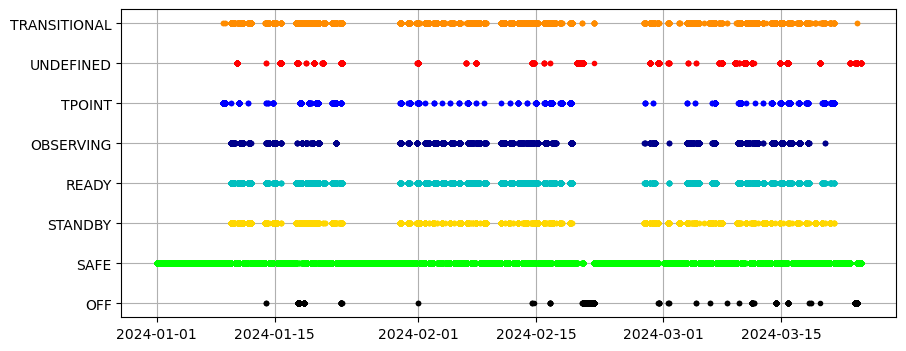

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
for key in dict_caco_states:
    mask_key = (value_tcu == key)
    ax.plot(date_tcu[mask_key], value_str_tcu[mask_key], marker=".", ls="", color=dict_caco_state_colors[key])
ax.grid()
plt.show()